# Adding in tracking of the non-transcribed mRNA strand (i.e. damage will just continue to accumulate with no repair)
# Not actually sure how to add in probability of restart?
# Have added a single line to keep track of amount of visible damages to RNAP

In [40]:
beta = 5.0
Pd = 0.9
d = 90

print(beta * (1-(1-Pd)**d))
print(beta*Pd*d)

5.0
405.0


In [41]:
import tqdm
import bokeh
import numpy as np
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span

# population vector:
# [Healthy mRNA, Damaged mRNA, Damage on Gene (tr strand), Gene Status, Damage on Gene (untr strand)]
# [     0,              1,              2,                      3,                  4,              ]

# Column 0 is change in m, column 1 is change in p
simple_update = np.array([[1, 0, 0, 0, 0],    # Make Healthy mRNA transcript
                        [0, 1, 0, 0, 0],      # Make Damaged mRNA transcript
                        [-1, 0, 0, 0, 0],     # Degrade Healthy mRNA transcript
                        [0, -1, 0, 0, 0],     # Degrade Damaged mRNA transcript
                        [0, 0, 1, 0, 1],      # Accumulate damage on gene (transcribed strand and untranscribed strand)
                        [0, 0, -1, 0, 0],     # Repair Damage on gene (only on transcribed strand)
                        [0, 1, 0, 0, 0],      # Do not detect damage and make damaged transcript
                        [0, 0, 0, 1, 0],      # Gene turns on
                        [0, 0, 0, -1, 0]      # Gene turns off
                        ], 
                        dtype=int)
                        
def sample_discrete(probs):
    """Randomly sample an index with probability given by probs."""
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1 # This is returning the reaction event that will occur

def simple_propensity(propensities, population, t, beta_m, gamma_m, u, Pd, gene_on, gene_off, Pv):
    """Updates an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    m_healthy = population[0] # number of healthy mRNAs
    m_damaged = population[1] # number of damaged mRNAs
    d = population[2] * Pv    # number of damage sites visible to RNAP
    G_state = population[3]   # 1 or 0 for gene being ON or OFF

    # Update propensities
    # these events rely on the gene being ON or OFF
    if G_state == 1:  # Gene is ON  
        # Update propensities
        if d == 0: # Gene is ON and has no damage

            propensities[0] = beta_m      # Make healthy mRNA transcript at rate beta_m if no damage on gene
            propensities[1] = 0           # Probability of Make damaged mRNA
            
            propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
            propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA
            propensities[4] = u           # Add a damage site to the gene
            propensities[5] = 0 # Detect damage site and repair
            propensities[6] = 0 # Do not detect damage site and transcribe mRNA (with error in it)
        
        else: # Gene is ON and has damage 

            propensities[0] = 0      # if there is damage on DNA, probability of making healthy mRNA = 0
            propensities[1] = 0      # Make damaged mRNA

            propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
            propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA

            propensities[4] = u           # Add a damage site to the gene
            #propensities[5] = beta_m * ((1-(1-Pd)**d)) # Detect damage site and repair
            propensities[5] = beta*Pd*d
            propensities[6] = beta_m * ((1-Pd)**d) # Do not detect damage site and transcribe mRNA (with error in it)

    else: # Gene is OFF (damage is irrelevant here)
        propensities[0] = 0 # no healthy mRNA production
        propensities[1] = 0 # no damaged mRNA production
        propensities[2] = m_healthy * gamma_m # Degrade healthy mRNA
        propensities[3] = m_damaged * gamma_m # Degrade damaged mRNA
        propensities[4] = u           # Add a damage site to the gene
        propensities[5] = 0 # no damage repair
        propensities[6] = 0 # no damage is missed / no damaged mRNA production
    
    propensities[7] = gene_on * (1 - G_state) # Gene turns ON, this will be zero if gene is already ON
    propensities[8] = gene_off * G_state      # Gene turns OFF, this will be zero if gene is already OFF
    
def gillespie_draw(propensity_func, propensities, population, t, args=()):
    """
    Draws a reaction and the time it took to do that reaction.
    
    Parameters
    ----------
    propensity_func : function
        Function with call signature propensity_func(population, t, *args)
        used for computing propensities. This function must return
        an array of propensities.
    population : ndarray
        Current population of particles
    t : float
        Value of the current time.
    args : tuple, default ()
        Arguments to be passed to `propensity_func`.
        
    Returns
    -------
    rxn : int
        Index of reaction that occured.
    time : float
        Time it took for the reaction to occur.
    """
    # Compute propensities
    propensity_func(propensities, population, t, *args)
    
    # Sum of propensities
    props_sum = propensities.sum()
    
    # Compute next time
    time = np.random.exponential(1.0 / props_sum)
    
    # Compute discrete probabilities of each reaction
    rxn_probs = propensities / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete(rxn_probs)
    
    return rxn, time



def gillespie_ssa(propensity_func, update, population_0, time_points, args=()):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from probability distribution of particle counts over time.
    
    Parameters
    ----------
    propensity_func : function
        Function of the form f(params, t, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
    args : tuple, default ()
        The set of parameters to be passed to propensity_func.        

    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.empty((len(time_points), 5), dtype=int) # the length always stays the same as the time points, but the second parameterr
                                                         # must match the amount of variables we are keeping track of

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy()
    pop_out[0,:] = population
    propensities = np.zeros(update.shape[0])
    while i < len(time_points):
        while t < time_points[i_time]:
            # draw the event and time step
            event, dt = gillespie_draw(propensity_func, propensities, population, t, args)
                
            # Update the population
            population_previous = population.copy()
            population += update[event]

            # can't have negative damage on the gene
            if population[2] < 0: # this needs to match whatever index I am keeping track of the damage at in population
                population[2] = 0
            
            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
                        
    return pop_out 

This served as a good base, model but some things I still don't fully understand, such as the dimensionless time aspect. If this is dimensionless, I am unsure how to get proper beta and gamma coefficients considering theres no time.

The sedimentation profiles of mRNA from HeLa and CHO cells indicate that the lengths of mammalian mRNA are lognormally distributed with a median value of 1.4 kb and a deviation of 2.0. This implies that, on the average, a mRNA species is only about 25% larger than the mature polypeptide it codes for. [https://link.springer.com/article/10.1007/BF01732582]

Could use this result to but in a good value for $\beta_m$
Could tailor this rate to deal with certain specific proteins we know the mRNA length of?
Maybe deal with the degradation rate in a similar way? [https://pmc.ncbi.nlm.nih.gov/articles/PMC403777/]

Unsure if this is the right direction to be going in for the model.


In [42]:
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span

# Specify parameters for calculation
beta_mrna = 10.0 # transcription rate
gamma_mrna = 0.1 # degradation rate
u = 1.0 # damage accumulation rate
Pd = 0.7 # rate of damage detection. must be between 0 and 1
gene_on = 0.8
gene_off = 1 - gene_on
Pv = 0.8

args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off, Pv)
time_points = np.linspace(0, 500, 1001)
population_0 = np.array([0, 0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF
size = 10

# Seed random number generator for reproducibility
np.random.seed(42)

# Initialize output array
samples = np.empty((size, len(time_points), 5), dtype=int) # again, change the number here to the amount of things we are tracking

# shape of samples is (size, time_points, amount of species)
# size = amount of times simulation is run
# time_points = amount of time points in each simulation
# amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

# Run the calculations
for i in tqdm.tqdm_notebook(range(size)):
    # this is storing the population at each time point for each simulation being ran (i)
    samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                population_0, time_points, args=args)
    

# Plotting
output_notebook()
plots = [bp.figure(width=600,
                 height=400,
                 title=f"mRNA counts with Beta {beta_mrna}, Gamma {gamma_mrna}",
                 x_axis_label='dimensionless time',
                 y_axis_label='number of Healthy mRNAs'),

         bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of Damaged mRNAs'),
                                
        bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='Damage sites on Gene'),
        
        bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='Total mRNAs')
                               ]

# Plot trajectories and mean
for i in range(0, 3): # this should loop over all the plots I want to make
    for x in samples[:,:,i]: # when i = 0, we are plotting population[0]
                             # when i = 1, we are plotting population[1] etc.
        
        # plot the individual simulation trajectories
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
        
    
    # this plots the mean path 
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=1, color='orange', line_join='bevel')

# Making my total plot, I could probably do something with indices here and avoid
# three separate loops, but this seems to work and speeds not an issue right now
for x in samples[:,:,0]:
    plots[3].line(time_points, x, line_width=0.3, alpha=0.2, line_join='bevel', color='blue') # Healthy mRNAs

for y in samples[:,:,1]:
    plots[3].line(time_points, y, line_width=0.3, alpha=0.2, line_join='bevel', color='red') # Damaged mRNAs

for z in (samples[:,:,0] + samples[:,:,1]):
    plots[3].line(time_points, z, line_width=0.3, alpha=0.2, line_join='bevel', color='purple') # total mRNAs

plots[3].line(time_points, samples[:,:,0].mean(axis=0), line_width=1, color='blue', line_join='bevel') # Average healthy mRNAs
plots[3].line(time_points, samples[:,:,1].mean(axis=0), line_width=1, color='red', line_join='bevel') # Average damaged mRNAs
plots[3].line(time_points, (samples[:,:,0] + samples[:, :, 1]).mean(axis=0), line_width=1, color='purple', line_join='bevel') # Average total mRNAs
    
# find the times when gene is on
gene_is_on = time_points * samples[:, :, 3]
gene_on_times = gene_is_on[np.where(gene_is_on != 0)] # get all time points when gene is on
gene_off_times = gene_is_on[np.where(gene_is_on == 0)] # get all time points when gene is off

# Actually not sure how to plot this as theres multiple samples, and doing an average of a binary variable (ON/OFF) is a bit of a pain


# Link axes
#plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

C:\Users\joeot\AppData\Local\Temp\ipykernel_27072\779078195.py:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/10 [00:00<?, ?it/s]

Loading BokehJS ...

In [43]:
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span

output_notebook()
# Set up plot for mRNA only
plot = bp.figure(width=600,
                 height=400,
                 title=f"mRNA counts with Beta {beta_mrna}, Gamma {gamma_mrna}",
                 x_axis_label='dimensionless time',
                 y_axis_label='number of mRNAs')

# Plot multiple trajectories
for x in samples[:, :, 0]:
    plot.line(time_points, x, line_width=0.3, alpha=0.2, line_join='bevel')

# Plot the mean trajectory
plot.line(time_points, samples[:, :, 0].mean(axis=0),
          line_width=4, color='orange', line_join='bevel', legend_label="mRNA Counts")

steady_state = beta_mrna / gamma_mrna

# Horizontal line
hline = Span(location=steady_state, dimension='width', line_color='red', line_width=2)

plot.renderers.extend([hline])

show(plot)

Loading BokehJS ...

In [44]:
plots = [bp.figure(width=600,
                 height=400,
                 title=f"mRNA counts with Beta {beta_mrna}, Gamma {gamma_mrna}",
                 x_axis_label='dimensionless time',
                 y_axis_label='number of Healthy mRNAs'),

         bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='number of Damaged mRNAs'),
                                
        bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='Damage sites on Gene'),
        
        bp.figure(width=600,
                               height=400,
                               x_axis_label='dimensionless time',
                               y_axis_label='Total mRNAs')
                               ]

# Plot trajectories and mean
for i in range(0, 3): # this should loop over all the plots I want to make
    for x in samples[:,:,i]: # when i = 0, we are plotting population[0]
                             # when i = 1, we are plotting population[1] etc.
        
        # plot the individual simulation trajectories
        plots[i].line(time_points, x, line_width=0.3, 
                      alpha=0.2, line_join='bevel')
        
    
    # this plots the mean path 
    plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                  line_width=1, color='orange', line_join='bevel')

# Making my total plot, I could probably do something with indices here and avoid
# three separate loops, but this seems to work and speeds not an issue right now
for x in samples[:,:,0]:
    plots[3].line(time_points, x, line_width=0.3, alpha=0.2, line_join='bevel', color='blue') # Healthy mRNAs

for y in samples[:,:,1]:
    plots[3].line(time_points, y, line_width=0.3, alpha=0.2, line_join='bevel', color='red') # Damaged mRNAs

for z in (samples[:,:,0] + samples[:,:,1]):
    plots[3].line(time_points, z, line_width=0.3, alpha=0.2, line_join='bevel', color='purple') # total mRNAs

plots[3].line(time_points, samples[:,:,0].mean(axis=0), line_width=1, color='blue', line_join='bevel') # Average healthy mRNAs
plots[3].line(time_points, samples[:,:,1].mean(axis=0), line_width=1, color='red', line_join='bevel') # Average damaged mRNAs
plots[3].line(time_points, (samples[:,:,0] + samples[:, :, 1]).mean(axis=0), line_width=1, color='purple', line_join='bevel') # Average total mRNAs
    
# find the times when gene is on
gene_is_on = time_points * samples[:, :, 3]
gene_on_times = gene_is_on[np.where(gene_is_on != 0)] # get all time points when gene is on
gene_off_times = gene_is_on[np.where(gene_is_on == 0)] # get all time points when gene is off

# Actually not sure how to plot this as theres multiple samples, and doing an average of a binary variable (ON/OFF) is a bit of a pain


# Link axes
#plots[0].x_range = plots[1].x_range

bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

In [45]:
#from simulation_funcs import gillespie_draw, gillespie_ssa, simple_propensity, simple_update
import bokeh
import tqdm
import numpy as np
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span
import matplotlib.pyplot as plt 

size = 10 # amount of simulations per run
betas = np.linspace(0, 15, 50) # beta values to test
average_damages_tr = np.zeros((len(betas), size))
average_damages_ntr = np.zeros((len(betas), size))

for j, beta in enumerate(betas):
    # Specify parameters for calculation
    beta_mrna =  beta # transcription rate
    gamma_mrna = 0.1 # degradation rate
    u = 1.0 # damage accumulation rate
    Pd = 0.8 # rate of damage detection. must be between 0 and 1
    Pv = 0.8 # proportion of damage visible to RNAP
    gene_on = 0.8
    gene_off = 1 - gene_on

    args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off, Pv)
    time_points = np.linspace(0, 500, 1001)
    population_0 = np.array([0, 0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF

    # Seed random number generator for reproducibility
    np.random.seed(42)

    # Initialize output array
    samples = np.empty((size, len(time_points), 5), dtype=int) # again, change the number here to the amount of things we are tracking

    # shape of samples is (size, time_points, amount of species)
    # size = amount of times simulation is run
    # time_points = amount of time points in each simulation
    # amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

    # Run the calculations
    for i in tqdm.tqdm_notebook(range(size)): # to print a progress bar
        # this is storing the population at each time point for each simulation being ran (i)
        samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                    population_0, time_points, args=args)
        #average_damages.append(samples[i,:,2].mean(axis=1)) # getting 
    average_damages_tr[j] = samples[:, :, 2].mean(axis=1) # getting the average damage over every simulation
    average_damages_ntr[j] = samples[:, :, 4].mean(axis=1) # getting the average damage over every simulation


C:\Users\joeot\AppData\Local\Temp\ipykernel_27072\3634117493.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)): # to print a progress bar


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'Average Damage over 1000 time units of 10 simulation')

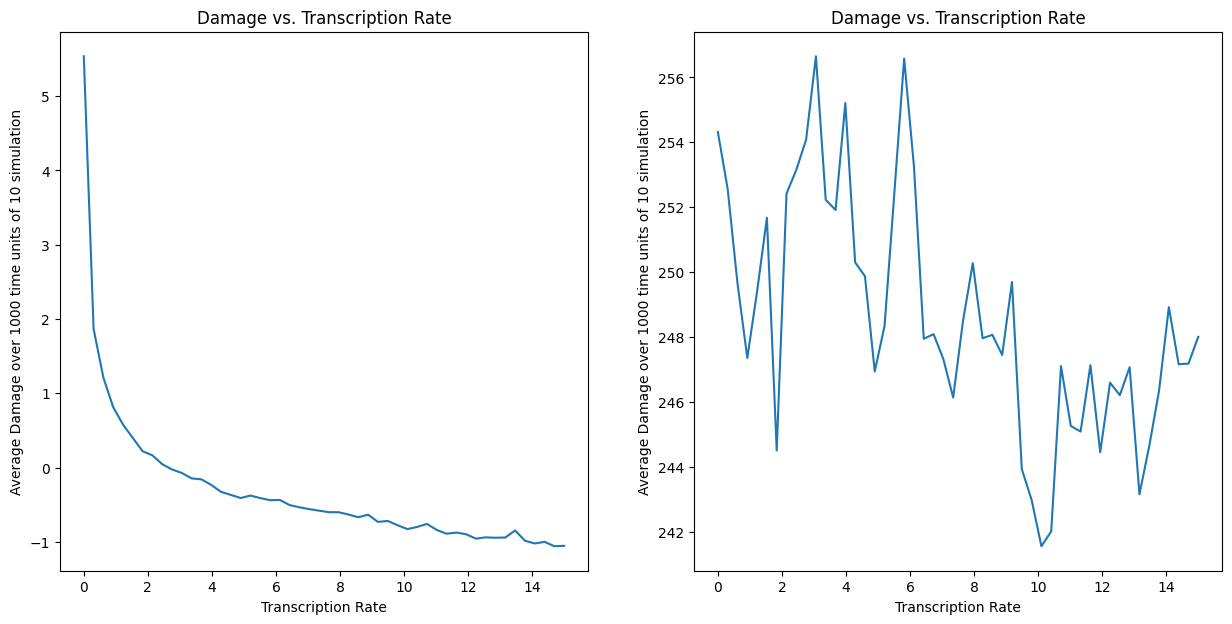

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

np.shape(average_damages_tr)
damages = average_damages_tr.mean(axis=1)
axes[0].plot(betas, np.log(damages))
axes[0].set_title('Damage vs. Transcription Rate')
axes[0].set_xlabel('Transcription Rate')
axes[0].set_ylabel('Average Damage over 1000 time units of 10 simulation')

damages_ntr = average_damages_ntr.mean(axis=1)
axes[1].plot(betas, (damages_ntr))
axes[1].set_title('Damage vs. Transcription Rate')
axes[1].set_xlabel('Transcription Rate')
axes[1].set_ylabel('Average Damage over 1000 time units of 10 simulation')

In [ ]:
#from simulation_funcs import gillespie_draw, gillespie_ssa, simple_propensity, simple_update
import bokeh
import tqdm
import numpy as np
import bokeh.plotting as bp
from bokeh.io import show, output_notebook
from bokeh.models import Span
import matplotlib.pyplot as plt 

size = 10 # amount of simulations per run
beta_vals = np.linspace(0, 15, 10) # beta values to test
burdens = []
transcriptions = []


for j, beta_mrna in enumerate(beta_vals):
    # Specify parameters for calculation
    beta_mrna =  beta # transcription rate
    gamma_mrna = 0.1 # degradation rate
    u = 1.0 # damage accumulation rate
    Pd = 0.8 # rate of damage detection. must be between 0 and 1
    Pv = 0.8 # proportion of damage visible to RNAP
    gene_on = 0.8
    gene_off = 1 - gene_on

    args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off, Pv)
    time_points = np.linspace(0, 500, 1001)
    population_0 = np.array([0, 0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF

    # Seed random number generator for reproducibility
    np.random.seed(42)

    # Initialize output array
    samples = np.empty((size, len(time_points), 5), dtype=int) # again, change the number here to the amount of things we are tracking

    # shape of samples is (size, time_points, amount of species)
    # size = amount of times simulation is run
    # time_points = amount of time points in each simulation
    # amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

    # Run the calculations
    for i in tqdm.tqdm_notebook(range(size)): # to print a progress bar
        # this is storing the population at each time point for each simulation being ran (i)
        samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                    population_0, time_points, args=args)
        

        healthy_mRNAs = 0
        damage_burden = np.zeros((size, len(time_points)))

        for j in range(0, len(time_points)):
            healthy_mRNAs += samples[i, j, 0]
            if (samples[i, j, 0] + samples[i, j, 1]) == 0:
                damage_burden[i, j] = 0
            else:
                damage_burden[i, j] = samples[i, j, 1] / (samples[i, j, 0] + samples[i, j, 1])

#average_healthy_mRNAs = healthy_mRNAs / (size*len(time_points))
#print(average_healthy_mRNAs)

        # healthy transcription levels
        transcriptions.append(samples[:, :, 0].mean(axis=1))

        # damage burden
        burdens.append(damage_burden.mean(axis=1))

AxisError: axis 1 is out of bounds for array of dimension 1

In [46]:
# population vector:
# [Healthy mRNA, Damaged mRNA, Damage on Gene (tr strand), Gene Status, Damage on Gene (untr strand)]
# [     0,              1,              2,                      3,                  4,              ]

# samples vector:
# [simluation number, time point, population]

# trying to get healthy transcription levels
# and plotting against damage burden
healthy_mRNAs = 0
damage_burden = np.zeros((size, len(time_points)))
for i in range(0, size):
    for j in range(0, len(time_points)):
        healthy_mRNAs += samples[i, j, 0]
        if (samples[i, j, 0] + samples[i, j, 1]) == 0:
            damage_burden[i, j] = 0
        else:
            damage_burden[i, j] = samples[i, j, 1] / (samples[i, j, 0] + samples[i, j, 1])

average_healthy_mRNAs = healthy_mRNAs / (size*len(time_points))
print(average_healthy_mRNAs)

# healthy transcription levels
samples[:, :, 0].mean(axis=1)

# damage burden
damage_burden.mean(axis=1)



27.22927072927073


array([0.07492711, 0.07861728, 0.08520831, 0.08717367, 0.09733148,
       0.07196279, 0.07020045, 0.09312604, 0.07340319, 0.0887031 ])

# Now trying to add cell lineages, to back up my drift claims as the cell replicates

this is in line with the original work of tracking lesion inheritance

In [47]:
def run_simulation(population_0, beta_mrna=10, gamma_mrna=0.1, u=1.0, Pd=0.7, gene_on=0.8, Pv=0.8):
    # Specify parameters for calculation
    beta_mrna = 10.0 # transcription rate
    gamma_mrna = 0.1 # degradation rate
    u = 1.0 # damage accumulation rate
    Pd = 0.7 # rate of damage detection. must be between 0 and 1
    gene_on = 0.8
    gene_off = 1 - gene_on
    Pv = 0.8

    args = (beta_mrna, gamma_mrna, u, Pd, gene_on, gene_off, Pv)
    time_points = np.linspace(0, 500, 1001)
    #population_0 = np.array([0, 0, 0, 0, 0], dtype=int) # starting with 0 population in everything and gene OFF
    size = 1

    # Seed random number generator for reproducibility
    np.random.seed(42)

    # Initialize output array
    samples = np.empty((size, len(time_points), 5), dtype=int) # again, change the number here to the amount of things we are tracking

    # shape of samples is (size, time_points, amount of species)
    # size = amount of times simulation is run
    # time_points = amount of time points in each simulation
    # amount of species = how many things we are tracking, mRNA, amount of damage on gene, etc.

    # Run the calculations
    for i in tqdm.tqdm_notebook(range(size)):
        # this is storing the population at each time point for each simulation being ran (i)
        samples[i,:,:] = gillespie_ssa(simple_propensity, simple_update,
                                    population_0, time_points, args=args)
    return samples[0, -1, :] # returning final population

def generation_sim(populations):

    next_generation = []

    for pop in populations:
        final_pop = run_simulation(pop) # run the simluation 
        daughter_1 = [0, 0, final_pop[2], 0, 0] # gets transcribed strand
        daughter_2 = [0, 0, final_pop[4], 0, final_pop[4]] # gets untranscribed strand

        next_generation.append(daughter_1)
        next_generation.append(daughter_2)

    return next_generation

def plot_sims(samples, args):
    plots = [bp.figure(width=600,
                    height=400,
                    title=f"mRNA counts with Beta {beta_mrna}, Gamma {gamma_mrna}",
                    x_axis_label='dimensionless time',
                    y_axis_label='number of Healthy mRNAs'),

            bp.figure(width=600,
                                height=400,
                                x_axis_label='dimensionless time',
                                y_axis_label='number of Damaged mRNAs'),
                                    
            bp.figure(width=600,
                                height=400,
                                x_axis_label='dimensionless time',
                                y_axis_label='Damage sites on Gene'),
            
            bp.figure(width=600,
                                height=400,
                                x_axis_label='dimensionless time',
                                y_axis_label='Total mRNAs')
                                ]

    # Plot trajectories and mean
    for i in range(0, 3): # this should loop over all the plots I want to make
        for x in samples[:,:,i]: # when i = 0, we are plotting population[0]
                                # when i = 1, we are plotting population[1] etc.
            
            # plot the individual simulation trajectories
            plots[i].line(time_points, x, line_width=0.3, 
                        alpha=0.2, line_join='bevel')
            
        
        # this plots the mean path 
        plots[i].line(time_points, samples[:,:,i].mean(axis=0),
                    line_width=1, color='orange', line_join='bevel')

    # Making my total plot, I could probably do something with indices here and avoid
    # three separate loops, but this seems to work and speeds not an issue right now
    for x in samples[:,:,0]:
        plots[3].line(time_points, x, line_width=0.3, alpha=0.2, line_join='bevel', color='blue') # Healthy mRNAs

    for y in samples[:,:,1]:
        plots[3].line(time_points, y, line_width=0.3, alpha=0.2, line_join='bevel', color='red') # Damaged mRNAs

    for z in (samples[:,:,0] + samples[:,:,1]):
        plots[3].line(time_points, z, line_width=0.3, alpha=0.2, line_join='bevel', color='purple') # total mRNAs

    plots[3].line(time_points, samples[:,:,0].mean(axis=0), line_width=1, color='blue', line_join='bevel') # Average healthy mRNAs
    plots[3].line(time_points, samples[:,:,1].mean(axis=0), line_width=1, color='red', line_join='bevel') # Average damaged mRNAs
    plots[3].line(time_points, (samples[:,:,0] + samples[:, :, 1]).mean(axis=0), line_width=1, color='purple', line_join='bevel') # Average total mRNAs
        
    # find the times when gene is on
    gene_is_on = time_points * samples[:, :, 3]
    gene_on_times = gene_is_on[np.where(gene_is_on != 0)] # get all time points when gene is on
    gene_off_times = gene_is_on[np.where(gene_is_on == 0)] # get all time points when gene is off

    # Actually not sure how to plot this as theres multiple samples, and doing an average of a binary variable (ON/OFF) is a bit of a pain


    # Link axes
    #plots[0].x_range = plots[1].x_range

    bokeh.io.show(bokeh.layouts.gridplot(plots, ncols=4))

#samples = run_simulations()
#plot_sims(samples)

In [48]:
# Generation 0 (root)
gen0 = [[0, 0, 0, 0, 0]]
gen1 = generation_sim(gen0)
gen2 = generation_sim(gen1)
gen3 = generation_sim(gen2)
gen4 = generation_sim(gen3)
gen5 = generation_sim(gen4)

C:\Users\joeot\AppData\Local\Temp\ipykernel_27072\3087426537.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(size)):


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
gen5

[[0, 0, 0, 0, 0],
 [0, 0, 501, 0, 501],
 [0, 0, 0, 0, 0],
 [0, 0, 989, 0, 989],
 [0, 0, 0, 0, 0],
 [0, 0, 501, 0, 501],
 [0, 0, 1, 0, 0],
 [0, 0, 1492, 0, 1492],
 [0, 0, 0, 0, 0],
 [0, 0, 501, 0, 501],
 [0, 0, 0, 0, 0],
 [0, 0, 989, 0, 989],
 [0, 0, 0, 0, 0],
 [0, 0, 495, 0, 495],
 [0, 0, 0, 0, 0],
 [0, 0, 1994, 0, 1994],
 [0, 0, 0, 0, 0],
 [0, 0, 501, 0, 501],
 [0, 0, 0, 0, 0],
 [0, 0, 989, 0, 989],
 [0, 0, 0, 0, 0],
 [0, 0, 501, 0, 501],
 [0, 0, 1, 0, 0],
 [0, 0, 1492, 0, 1492],
 [0, 0, 0, 0, 0],
 [0, 0, 501, 0, 501],
 [0, 0, 1, 0, 0],
 [0, 0, 987, 0, 987],
 [0, 0, 0, 0, 0],
 [0, 0, 501, 0, 501],
 [0, 0, 0, 0, 0],
 [0, 0, 2484, 0, 2484]]